# Autoencoders

Import the libraries.

In [285]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import os
from torchvision.utils import save_image

from os.path import exists

Utility functions, to store the temporary images and to convert matrix shape.

In [ ]:
if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')
    
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

## Dataset

In [202]:
num_epochs = 100
batch_size = 128
learning_rate = 1e-3

# Transforms images to a PyTorch Tensor
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)
])

# Download the MNIST Dataset
dataset = datasets.MNIST(root = "./data", train = True,download = True,transform = img_transform)

# DataLoader is used to load the dataset
# for training
loader = torch.utils.data.DataLoader(dataset = dataset,batch_size = batch_size,shuffle = True)

## Model

In [203]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [282]:
# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
class AE(torch.nn.Module):

    def __init__(self):
        super().__init__()

        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 2),
            torch.nn.ReLU()
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(2, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 28 * 28),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded,decoded

In [283]:
# Model Initialization
model = AE()
#moving to gpu
model.to(device)

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate,weight_decay = 1e-5)

## Training / Loading

In [286]:
model_file = "autoencoder_2.pth"

epoch [1/100], loss:0.9227
epoch [2/100], loss:0.9262
epoch [3/100], loss:0.9245
epoch [4/100], loss:0.9268
epoch [5/100], loss:0.9245
epoch [6/100], loss:0.9246
epoch [7/100], loss:0.9276
epoch [8/100], loss:0.9266
epoch [9/100], loss:0.9291
epoch [10/100], loss:0.9265
epoch [11/100], loss:0.9238
epoch [12/100], loss:0.9262
epoch [13/100], loss:0.9287
epoch [14/100], loss:0.9280
epoch [15/100], loss:0.9212
epoch [16/100], loss:0.9297
epoch [17/100], loss:0.9270
epoch [18/100], loss:0.9270
epoch [19/100], loss:0.9257
epoch [20/100], loss:0.9288
epoch [21/100], loss:0.9247
epoch [22/100], loss:0.9208
epoch [23/100], loss:0.9172
epoch [24/100], loss:0.9182
epoch [25/100], loss:0.9160
epoch [26/100], loss:0.9148
epoch [27/100], loss:0.9141
epoch [28/100], loss:0.9103
epoch [29/100], loss:0.9118
epoch [30/100], loss:0.9144
epoch [31/100], loss:0.9133
epoch [32/100], loss:0.9123
epoch [33/100], loss:0.9123
epoch [34/100], loss:0.9094
epoch [35/100], loss:0.9110
epoch [36/100], loss:0.9082
e

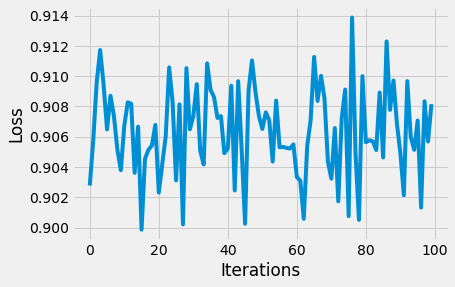

In [284]:
if exists(model_file):
    model.load_state_dict(torch.load(model_file))
    model.eval()
else:
    losses = []
    for epoch in range(num_epochs):
        for data in loader:
            image, label = data

            # Reshaping the image to (-1, 784)
            image = image.view(image.size(0), -1)
            #image = image.reshape(-1, 28*28)

            # Output of Autoencoder
            image = image.to(device)

            _,reconstructed = model(image)

            # Calculating the loss function
            loss = loss_function(reconstructed, image)

            # The gradients are set to zero,
            # the the gradient is computed and stored.
            # .step() performs parameter update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Storing the losses in a list for plotting
            losses.append(loss)
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.data))
        if epoch % 10 == 0:
            pic = to_img(reconstructed.cpu().data)
            save_image(pic, './mlp_img/image_{}.png'.format(epoch))

    torch.save(model.state_dict(), model_file)
    model.eval()
    # Defining the Plot Style
    plt.style.use('fivethirtyeight')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')

    # Plotting the last 100 values
    plt.plot(losses[-100:])

## Display sample images

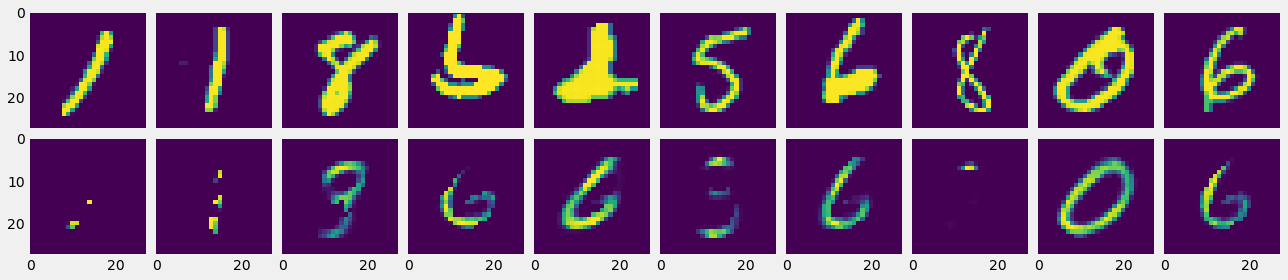

In [288]:
import random
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid
model.eval()
model.to("cpu")
fig = plt.figure(figsize=(20., 5.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 10),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


for i in range(10):
    image,_ = dataset.__getitem__(random.randint(1,37000))

    img = image.reshape(-1, 28*28)
    _,reconstructed = model(img)
    item = reconstructed.reshape(-1, 28, 28)
    item = item.detach().numpy()

    # Iterating over the grid returns the Axes.
    grid[i].imshow(image[0])
    grid[i].grid(False)
    grid[10+i].imshow(item[0])
    grid[10+i].grid(False)


plt.savefig("nums.png",transparent=True)
plt.show()


## Display latent space

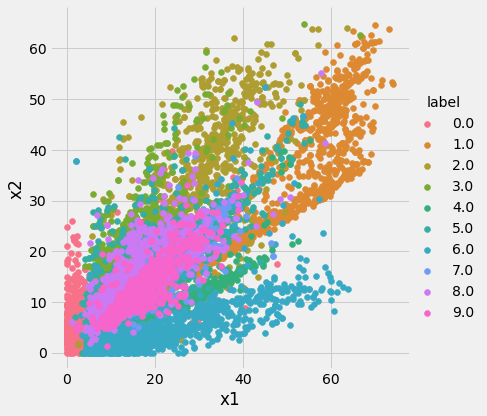

In [355]:
import seaborn as sns
import pandas as pd

latents = []
for i in range(10000):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    latent,output = model(img.reshape(-1,28*28))
    latents.append(np.append(latent.detach().numpy(),label))

latarray = np.stack(latents, axis=0 )
df = pd.DataFrame(data=latarray, columns=("x1", "x2", "label"))
sns.FacetGrid(df, hue="label", height=6).map(plt.scatter, 'x1', 'x2').add_legend()
plt.savefig("latent_space.png",transparent=True)
plt.show()


In [357]:
data_types_dict = {'label': int}
df = df.astype(data_types_dict)
print(df.dtypes)

x1       float64
x2       float64
label      int64
dtype: object


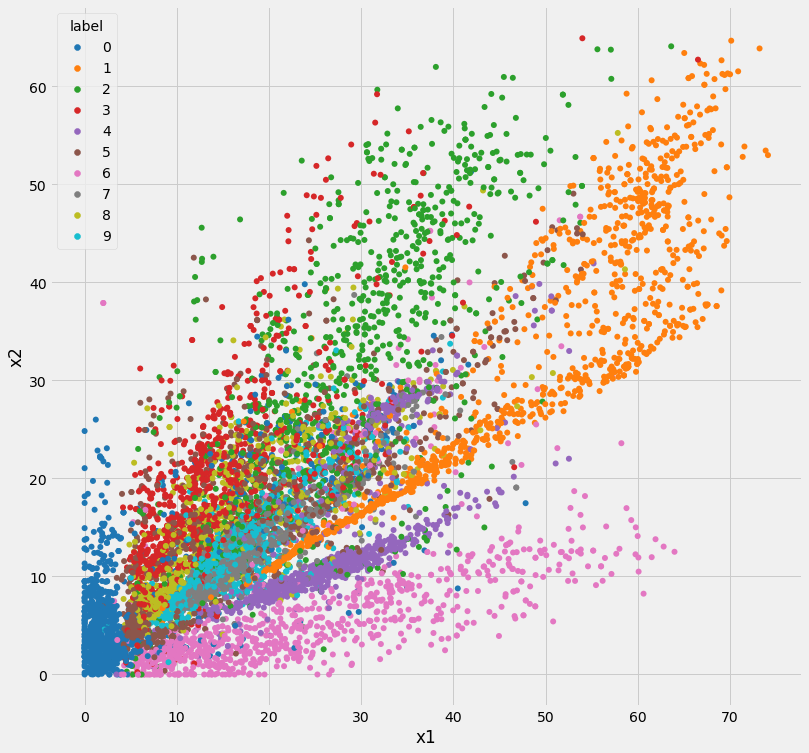

In [368]:
f, ax = plt.subplots(figsize=(12, 12))
#sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="x1", y="x2",
                hue="label",
                legend="full",
                palette="tab10",
                linewidth=0,
                data=df, ax=ax)
plt.savefig("latent_space.png",transparent=True)